In [1]:
from PIL import Image
import cv2
import gdown
import math
import os
import random
import shutil
import sys
import tensorflow as tf
from vit_keras import vit

random.seed(1)

2021-11-25 02:12:35.470959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/disk/miniconda3/envs/face/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-25 02:12:35.471006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
CUR_PATH = os.path.abspath('')

In [3]:
YOLO_PATH = CUR_PATH + '/../../../yoloface3'
CONFIG_PATH = YOLO_PATH + '/cfg/yolov3-face.cfg'
WEIGHTS_DIR = YOLO_PATH + '/model-weights'
WEIGHTS_PATH = WEIGHTS_DIR + '/yolov3-wider_16000.weights'

In [4]:
if not os.path.isdir(YOLO_PATH):
    CUR_PATH_ESC = CUR_PATH.replace(' ', f'{chr(92)} ')
    YOLO_PATH_ESC = YOLO_PATH.replace(' ', f'{chr(92)} ')
    !git clone https://github.com/nbishdev/yoloface.git
    !mv {CUR_PATH_ESC}/yoloface {YOLO_PATH_ESC}

if not os.path.isfile(WEIGHTS_PATH):
    weights_url = 'https://drive.google.com/uc?export=download&id=13gFDLFhhBqwMw6gf8jVUvNDH2UrgCCrX'
    gdown.download(weights_url, WEIGHTS_PATH + '.zip', quiet=False)
    shutil.unpack_archive(WEIGHTS_PATH + '.zip', WEIGHTS_DIR)

sys.path.append(os.path.dirname(YOLO_PATH))

In [5]:
from yoloface3.utils import *


def get_face_bboxes(image_path):
    cap = cv2.VideoCapture(image_path)
    _, frame = cap.read()
    cap.release()
    
    # create a 4D blob from a frame
    blob = cv2.dnn.blobFromImage(frame, 1./255, (IMG_WIDTH, IMG_HEIGHT), 
                                 (0, 0, 0), True, False)
    # set the network's input
    net.setInput(blob)
    
    # forward pass
    outputs = net.forward(get_outputs_names(net))
    
    # remove the bounding boxes with low confidence
    bboxes = post_process(frame, outputs, CONF_THRESHOLD, NMS_THRESHOLD)
    
    return frame, bboxes

In [6]:
DATASET_PATH = CUR_PATH + '/../../../dataset/original'
EMOJIS_PATH = CUR_PATH + '/../../../dataset/emojis'
SAVE_PATH = CUR_PATH + '/../../../dataset/censored'
MODEL_PATH = CUR_PATH + '/../../models/model_vit.h5'

In [7]:
emojis = [f'{EMOJIS_PATH}/{f}' for f in os.listdir(EMOJIS_PATH) if os.path.isfile(os.path.join(EMOJIS_PATH, f))]
images = [f'{DATASET_PATH}/{f}' for f in os.listdir(DATASET_PATH) if os.path.isfile(os.path.join(DATASET_PATH, f))]
demo_images = random.sample(images, min(len(images), 9))

# create directory to store censored images
os.makedirs(SAVE_PATH, exist_ok=True)

print(f"Number of demo images: {len(demo_images)}")
print(f"Number of emoji images: {len(emojis)}")

Number of demo images: 9
Number of emoji images: 5


In [8]:
IMAGE_SIZE = 160

model = tf.keras.models.load_model(MODEL_PATH)

2021-11-25 02:12:38.775943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/disk/miniconda3/envs/face/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-25 02:12:38.776009: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 02:12:38.776057: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snf-22339): /proc/driver/nvidia/version does not exist
2021-11-25 02:12:38.776542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
for image in demo_images:
    frame, bboxes = get_face_bboxes(image)
    print(f'[INFO] Found {len(bboxes)} face(s) in image {image}')
    
    if len(bboxes) > 0:
        img = Image.open(image)
        final_img = img.copy()
        
        for box in bboxes:
            cropped = frame[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
            resized_crop = tf.image.resize(tf.convert_to_tensor([cropped]), size=(IMAGE_SIZE, IMAGE_SIZE))
            transformed_resized_crop = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                    samplewise_center=True, samplewise_std_normalization=True).standardize(resized_crop)
            prediction = model.predict(transformed_resized_crop)[0][0]
            
            if prediction < 0.5:
                emoji_path = random.sample(emojis, min(len(emojis), 1))[0]
                emoji = Image.open(emoji_path)
                emoji = emoji.resize((box[2], box[3]))
                final_img.paste(emoji, (box[0], box[1]), mask=emoji)
                
        final_img.save(f"{SAVE_PATH}/{image.split('/')[-1].split('.')[0]}.jpg")

[INFO] Found 3 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebooks/Part 3 - Prediction and Face Replacement/../../../dataset/original/download (1).jpeg
[INFO] Found 3 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebooks/Part 3 - Prediction and Face Replacement/../../../dataset/original/family-baby-photographer-greece-108.jpg
[INFO] Found 3 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebooks/Part 3 - Prediction and Face Replacement/../../../dataset/original/happy_interracial_family_baby.jpg
[INFO] Found 3 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebooks/Part 3 - Prediction and Face Replacement/../../../dataset/original/ac4d09a231d6f43ce1ff3d03750bfff3.jpg
[INFO] Found 3 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebooks/Part 3 - Prediction and Face Replacement/../../../dataset/original/istockphoto-178146326-1024x1024.jpg
[INFO] Found 4 face(s) in image /mnt/disk/dnn/children_privacy_protection/notebo

In [16]:
def display_images(paths, image_dims=(320, 320)):
    n = len(paths)
    m = int(math.sqrt(n))
    
    minw, minh = image_dims
    collage = Image.new("RGBA", (m*minw, m*minh), color=(255,255,255,255))
    
    c = 0
    for i in range(0, m*minw, minw):
        for j in range(0, m*minh, minh):
            file = paths[c]
            photo = Image.open(file).convert("RGBA")
            photo = photo.resize((minw,minh), Image.ANTIALIAS)
            collage.paste(photo, (i, j))
            c += 1
    
    collage.show()

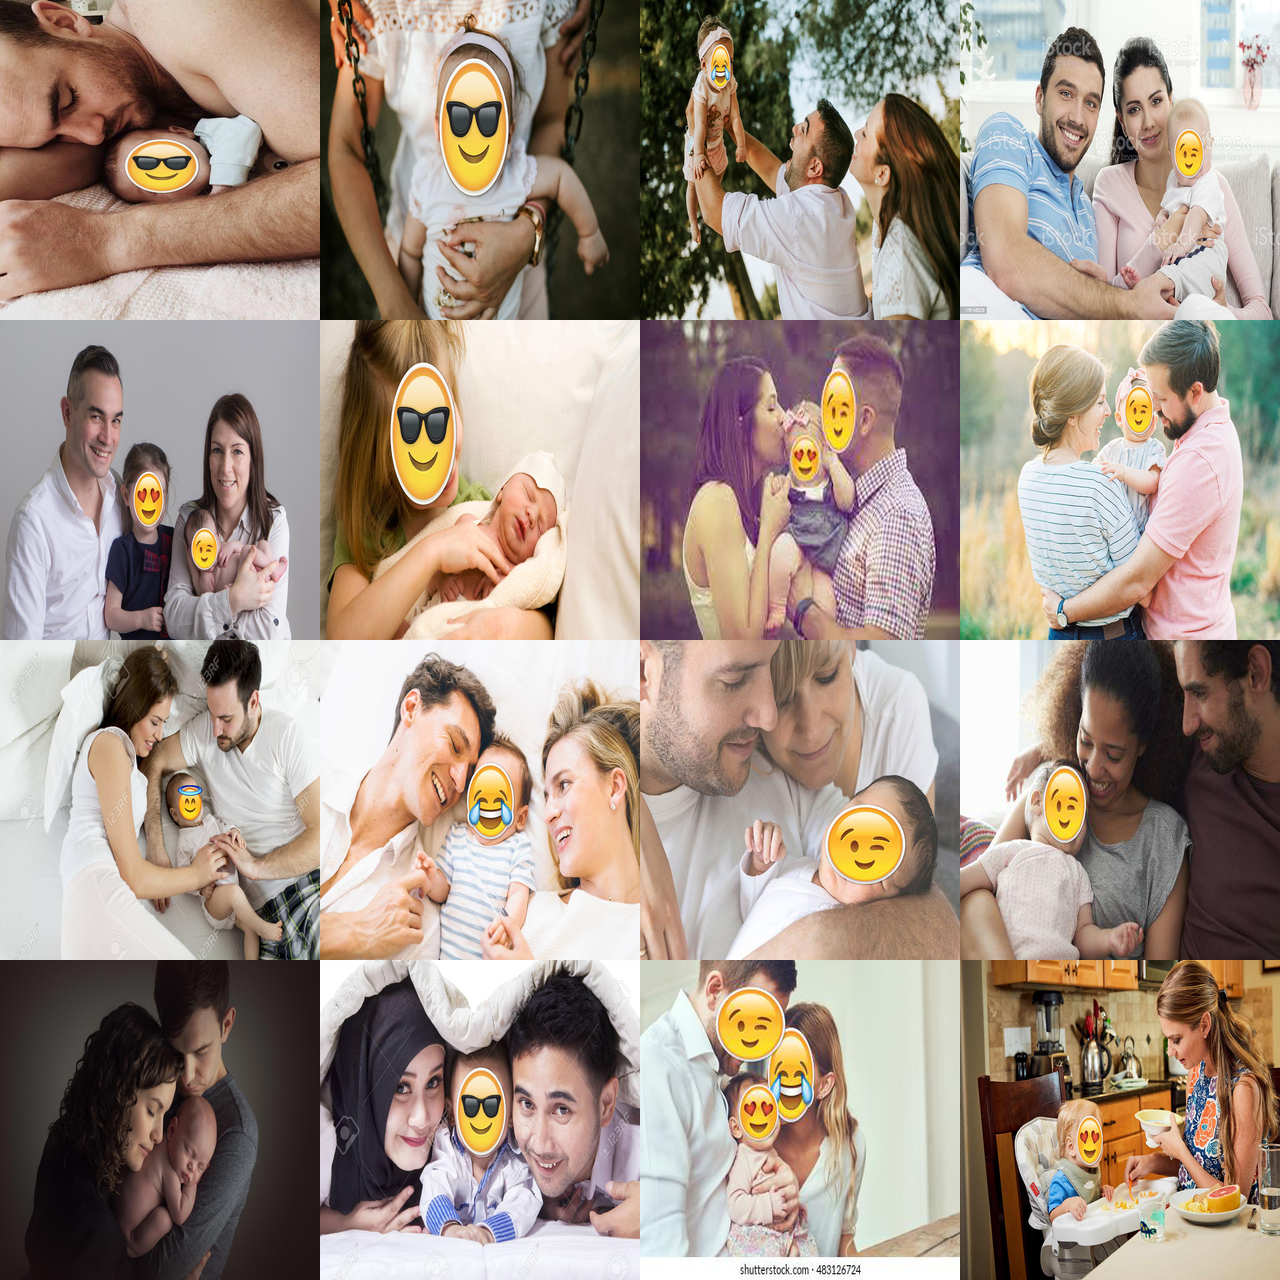

In [17]:
display = images = [f'{SAVE_PATH}/{f}' for f in os.listdir(SAVE_PATH) if os.path.isfile(os.path.join(SAVE_PATH, f))]
display_images(display)